# Train and test split + Copying images into train and test folders

## 1. Reload images dataset

In [1]:
import pandas as pd

images_dataset_path = 'data/datasets/images_clean.csv'
df_images = pd.read_csv(images_dataset_path)

display(df_images.columns)
print()
display(df_images.index[:10])

Index(['id_video', 'code', 'folder', 'file_name', 'file_path', 'frame_index',
       'timestamp', 'initial_timestamp', 'seen', 'tags', 'tag', 'flood'],
      dtype='object')

RangeIndex(start=0, stop=10, step=1)

---
## 2. Preprocess the dataset

In [2]:
from modules.octa_video_util import filter_by_query

#### Drop categories

In [4]:
df_images = df_images[df_images['tag'] != 'transbordo']

#### Filter images

In [6]:
query_params = {'seen': True}

# Filter dataset of images by query
df_images = filter_by_query(df_images, query_params).copy()

display(df_images['flood'].value_counts())
print()
display(df_images.index[:10])

flood
0    224682
1     20865
Name: count, dtype: int64

Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='int64')

---
## 3. Shuffling

#### Sampling parameters

In [7]:
target_variable = 'flood'
multiclass_target_variable = 'tag'
groups_variable = 'code'

# max_samples = 2000
replace = False
random_state = 3

# Copy the data for analysis
data = df_images.copy()

#### Shuffle Samples

In [8]:
data = data.sample(n=len(data), replace=replace, random_state=random_state)

display(data.index[:10])

Index([242852, 132211, 54294, 148185, 230928, 183100, 20092, 69993, 242268,
       24304],
      dtype='int64')

#### Get x and y (features and target variable)

In [9]:
# Get x and y
X = data.drop(target_variable, axis=1)
Y = data[target_variable].copy()

Y_multi = data[multiclass_target_variable] 
groups = data[groups_variable].copy()

display(Y.value_counts())
print()
display(Y_multi.value_counts())

flood
0    226919
1     20865
Name: count, dtype: int64

tag
normal        154843
poça           69839
bolsão         10621
lâmina          5218
alagamento      5026
transbordo      2237
Name: count, dtype: int64

---
### 4. Split images based on camera codes

#### Utility functions

In [165]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

def group_even_undersample(x, y, groups, prct=0.5, n=None, random_state=None):
    group_cnt = groups.value_counts()
    if n is None:
            n = int(np.percentile(group_cnt, prct * 100))
    index = []
    for group in group_cnt.index:
        index += y[groups == group].sample(min(n, group_cnt[group]), replace=False, random_state=random_state).index.tolist()
    return x.loc[index], y.loc[index]

def group_even_class_undersample(x, y, groups, n, random_state=None):
    msk_0 = y == 0.0
    msk_1 = y == 1.0
    
    x_even_0, y_even_0 = group_even_undersample(x[msk_0], y[msk_0], groups[msk_0], n=n, random_state=random_state)
    x_even_1, y_even_1 = group_even_undersample(x[msk_1], y[msk_1], groups[msk_1], n=n, random_state=random_state)
    
    y_even = pd.concat([y_even_0, y_even_1])
    x_even = x.loc[y_even.index]
    groups_even = groups.loc[y_even.index]

    return x_even, y_even, groups_even
def report_class_count_per_group(Y, groups):
    cnt_0 = groups[Y == 0.0].value_counts()
    cnt_1 = groups[Y == 1.0].value_counts()
    cnt_0 = cnt_0.loc[cnt_1.index].sort_values(ascending=False)
    code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
    
    display(code_class_cnt.T)
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.subplots(1, 1)
    code_class_cnt.plot.bar(width=0.8, ax=ax)
    plt.show()

def group_split_report(y_res, groups_res, train_index, test_index, val_index):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    
    train_prct = len(Y_train) / len(y_res)
    test_prct = len(Y_test) / len(y_res)
    val_prct = len(Y_val) / len(y_res)
    class_count = y_res.value_counts()
    train_class_count = Y_train.value_counts()
    test_class_count = Y_test.value_counts()
    val_class_count = Y_val.value_counts()
    groups_train = groups_res.loc[Y_train.index].unique()
    groups_test = groups_res.loc[Y_test.index].unique()
    groups_val = groups_res.loc[Y_val.index].unique()

    total_groups = len(groups_res.unique())
    groups_train_prct = round(len(groups_train) / total_groups * 100, 2)
    groups_test_prct = round(len(groups_test) / total_groups * 100, 2)
    groups_val_prct = round(len(groups_val) / total_groups * 100, 2)
    train_class_prct = [train_class_count[0] / class_count[0], train_class_count[1] / class_count[1]]
    test_class_prct = [test_class_count[0] / class_count[0], test_class_count[1] / class_count[1]]
    val_class_prct = [val_class_count[0] / class_count[0], val_class_count[1] / class_count[1]]
    train_class_ratio = round(Y_train.value_counts(normalize=True).loc[0] * 100, 2)
    test_class_ratio = round(Y_test.value_counts(normalize=True).loc[0] * 100, 2)
    val_class_ratio = round(Y_val.value_counts(normalize=True).loc[0] * 100, 2)
    
    print('Groups intersecting train and test sets:', len(set(groups_train).intersection(groups_test)))
    print('Groups intersecting train and val sets:', len(set(groups_train).intersection(groups_val)))
    print('Groups intersecting test and val sets:', len(set(groups_test).intersection(groups_val)))
    print()
    
    stats = pd.DataFrame(
        [[len(groups_train), len(groups_test), len(groups_val)],
        [groups_train_prct, groups_test_prct, groups_val_prct],
        [len(Y_train), len(Y_test), len(Y_val)],
        [round(train_prct * 100, 2), round(test_prct * 100, 2), round(val_prct * 100, 2)],
        [train_class_count[0], test_class_count[0], val_class_count[0]],
        [train_class_count[1], test_class_count[1], val_class_count[1]],
        [round(train_class_prct[0] * 100, 2), round(test_class_prct[0] * 100, 2), round(val_class_prct[0] * 100, 2)],
        [round(train_class_prct[1] * 100, 2), round(test_class_prct[1] * 100, 2), round(val_class_prct[1] * 100, 2)],
        [train_class_ratio, test_class_ratio, val_class_ratio]],
        columns=['train', 'test', 'val'], index=['groups', 'groups (%)', 'total', 'total (%)', '0', '1', '0 (%)', '1 (%)', 'class ratio (%)']
    ).T

    return stats


def group_class_count_plot(y, groups, train_index, test_index, val_index):

    Y_train = y.loc[train_index]
    Y_test = y.loc[test_index]
    Y_val = y.loc[val_index]
    groups_train = groups.loc[train_index]
    groups_test = groups.loc[test_index]
    groups_val = groups.loc[val_index]
    
    for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
    
        cnt_0 = g_i[y_i == 0.0].value_counts()
        cnt_1 = g_i[y_i == 1.0].value_counts()
        cnt_0 = cnt_0.loc[cnt_1.index]
        
        code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
        code_class_cnt.index.name = f'codes'
        code_class_cnt.columns.name = title
        display(code_class_cnt.T)
    
    for y_i, g_i, title in zip((Y_train, Y_test, Y_val), (groups_train, groups_test, groups_val), ('Train', 'Test', 'Validation')):
    
        cnt_0 = g_i[y_i == 0.0].value_counts()
        cnt_1 = g_i[y_i == 1.0].value_counts()
        cnt_0 = cnt_0.loc[cnt_1.index]
        
        code_class_cnt = pd.concat([cnt_0.rename('class 0'), cnt_1.rename('class 1')], axis=1)
        code_class_cnt.index.name = f'codes'
        code_class_cnt.columns.name = title
        
        fig = plt.figure(figsize=(7, 2.5))
        ax = fig.subplots(1, 1)
        
        code_class_cnt.plot.bar(width=0.8, ax=ax, title=title)
        # plt.legend(loc='lower left')
        # plt.tight_layout()
        plt.show()

#### Get camera codes for cameras with and without positive samples

In [101]:
codes = data['code'].unique().tolist()
codes_1 = data[data['flood'] == 1.0]['code'].unique().tolist()
codes_0 = list(set(codes).difference(codes_1))

print('All cameras:', len(codes))
print('Cameras with positive class:', len(codes_1))
print('Cameras without positive class:', len(codes_0))

All cameras: 201
Cameras with positive class: 30
Cameras without positive class: 171


#### Split codes based on percentage 

In [79]:
import random

def sample(objs, size=1, frac=None, seed=42):
    random.seed(seed)
    if frac is not None:
        size = int(frac * len(objs))
    return random.sample(objs, size)


# Sample uniformly
train_size = 0.6
test_size = 0.2
val_size = 0.2

train_frac = train_size
test_frac = test_size / (1.0 - train_size) 
val_frac = val_size / (1.0 - train_size - test_size) 

codes_0_train = sample(codes_0, frac=train_frac, seed=random_state)
codes_1_train = sample(codes_1, frac=train_frac, seed=random_state)

codes_0_out = list(set(codes_0).difference(codes_0_train))
codes_1_out = list(set(codes_1).difference(codes_1_train))

codes_0_test = sample(codes_0_out, frac=test_frac, seed=random_state)
codes_1_test = sample(codes_1_out, frac=test_frac, seed=random_state)

codes_0_out = list(set(codes_0_out).difference(codes_0_test))
codes_1_out = list(set(codes_1_out).difference(codes_1_test))

codes_0_val = sample(codes_0_out, frac=val_frac, seed=random_state)
codes_1_val = sample(codes_1_out, frac=val_frac, seed=random_state)

codes_train = codes_0_train + codes_1_train
codes_test = codes_0_test + codes_1_test
codes_val = codes_0_val + codes_1_val

print('n_codes_train:', len(codes_train))
print('n_codes_test:', len(codes_test))
print('n_codes_val:', len(codes_val))
print()
print('codes_train:', codes_train[:5])
print('codes_test:', codes_test[:5])
print('codes_val:', codes_val[:5])

n_codes_train: 120
n_codes_test: 40
n_codes_val: 41

codes_train: [3181.0, 1469.0, 1405.0, 1598.0, 3261.0]
codes_test: [2167.0, 1092.0, 3268.0, 1392.0, 1576.0]
codes_val: [1383.0, 58.0, 183.0, 3269.0, 2165.0]


#### Split images based on splitted camera codes

In [88]:
data_train = data[data['code'].isin(codes_train)]
data_test = data[data['code'].isin(codes_test)]
data_val = data[data['code'].isin(codes_val)]

display(pd.concat([
    train['flood'].value_counts().to_frame('train'),
    test['flood'].value_counts().to_frame('test'),
    val['flood'].value_counts().to_frame('val')
], axis=1))

,train,test,val
flood,,,
0,147641,37814,41464
1,15148,1738,3979


#### Data x and y

In [140]:
x = data.drop('flood', axis=1)
y = data['flood']
groups = data['code']

#### Even groups class undersample

In [136]:
x_even, y_even, groups_even = group_even_class_undersample(x, y, groups, n=30, random_state=random_state)
y_multi_even = Y_multi.loc[y_even.index]

display(y_even.index)

Index([167457, 160401, 160768, 163512, 196018, 217576, 159387, 159300, 170070,
       182654,
       ...
       194236, 194245, 194247, 194242, 194235, 194241, 194243, 194239, 194237,
       194246],
      dtype='int64', length=6770)

#### Report class count per camera

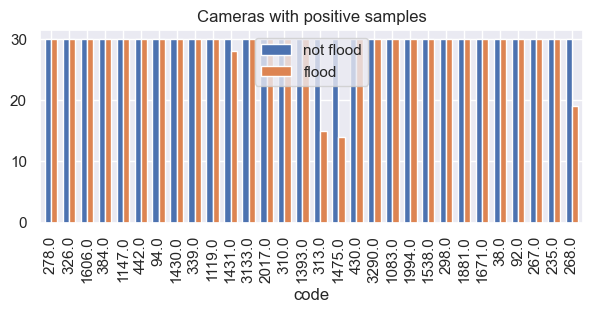

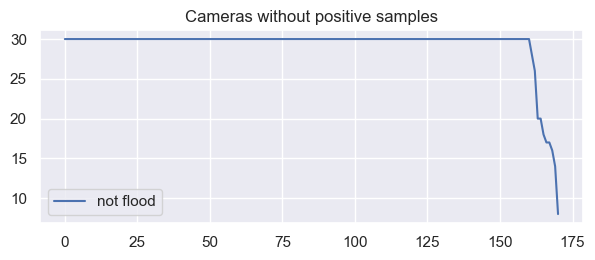

In [132]:
groups_even_1 = groups_even[groups_even.isin(codes_1)]
y_even_1 = y_even.loc[groups_even_1.index]

cls_cnt = pd.concat([
    groups_even_1[y_even_1 == 0.0].value_counts().rename('not flood'),
    groups_even_1[y_even_1 == 1.0].value_counts().rename('flood')
], axis=1)

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

cls_cnt.plot.bar(width=0.7, ax=ax)
plt.title('Cameras with positive samples')
plt.show()

groups_even_0 = groups_even[groups_even.isin(codes_0)]
y_even_0 = y_even.loc[groups_even_0.index]

fig = plt.figure(figsize=(7, 2.5))
ax = fig.subplots(1, 1)

groups_even_0.value_counts().reset_index(drop=True).rename('not flood').plot(ax=ax)
plt.title('Cameras without positive samples')
plt.legend()
plt.show()

#### Report class count

In [134]:
print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())

Total samples: 6770



flood
0    5914
1     856
Name: count, dtype: int64


tag
normal        3941
poça          1932
bolsão         322
alagamento     294
lâmina         240
transbordo      41
Name: count, dtype: int64



Index([167457, 160401, 160768, 163512, 196018, 217576, 159387, 159300, 170070,
       182654,
       ...
       194236, 194245, 194247, 194242, 194235, 194241, 194243, 194239, 194237,
       194246],
      dtype='int64', length=6770)

#### Build split with balanced train, test and validation

In [180]:
train_index = y_even[groups_even.isin(codes_1_train)].index
test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))
# group_class_count_plot(y, groups, train_index, test_index, val_index)

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,18.0,8.96,1051.0,15.52,540.0,511.0,9.13,59.70,51.38
test,6.0,2.99,360.0,5.32,180.0,180.0,3.04,21.03,50.00
val,6.0,2.99,345.0,5.10,180.0,165.0,3.04,19.28,52.17


#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [181]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/balanced_train'

# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 1051/1051 files (100.00%) - Found: 1051/1051
Copying images to test folders:
Processed 360/360 files (100.00%) - Found: 360/360
Copying images to val folders:


#### Save dataframe of sample images

In [176]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (1756, 13)


#### Build split with balanced test and validation

In [182]:
train_index = y_even[groups_even.isin(codes_train)].index
test_index = y_even[groups_even.isin(codes_1_test)].index
val_index = y_even[groups_even.isin(codes_1_val)].index

display(group_split_report(y_even, groups_even, train_index, test_index, val_index))
# group_class_count_plot(y, groups, train_index, test_index, val_index)

Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,120.0,59.70,4011.0,59.25,3500.0,511.0,59.18,59.70,87.26
test,6.0,2.99,360.0,5.32,180.0,180.0,3.04,21.03,50.00
val,6.0,2.99,345.0,5.10,180.0,165.0,3.04,19.28,52.17


#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [183]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/imbalanced_train'

# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_index, test_index, val_index,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 4011/4011 files (100.00%) - Found: 4011/4011
Copying images to test folders:
Processed 360/360 files (100.00%) - Found: 360/360
Copying images to val folders:


#### Save dataframe of sample images

In [184]:
import os

os.makedirs(target_directory, exist_ok=True)

data_train = data.loc[train_index].copy()
data_test = data.loc[test_index].copy()
data_val = data.loc[val_index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (4716, 13)


---
## 4. Balanced sample per camera

#### Report class count per camera (only cameras with positive samples)

code,278.0,326.0,235.0,267.0,92.0,38.0,1671.0,1881.0,298.0,1538.0,...,1431.0,1119.0,339.0,1430.0,94.0,442.0,1147.0,384.0,1606.0,268.0
class 0,14206,10354,8249,6324,4076,2790,2700,2560,2252,2028,...,277,264,250,232,225,202,195,162,127,69
class 1,8185,1112,1383,285,231,180,270,540,2387,2132,...,28,40,125,90,225,630,315,225,109,19


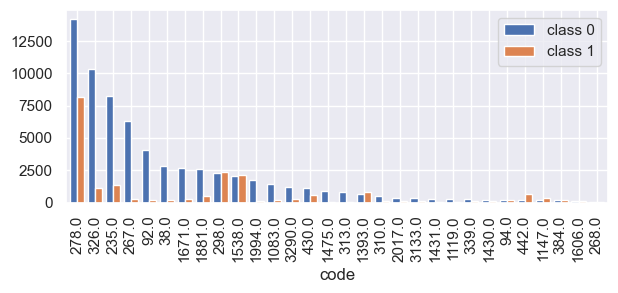

In [68]:
report_class_count_per_group(Y, groups)

#### Undersample per camera

In [69]:
cnt_0 = groups[Y == 0.0].value_counts()
cnt_1 = groups[Y == 1.0].value_counts()

index = []
for code in cnt_1.index:
    Y_code = Y[groups == code]
    n_samples = min(cnt_0.loc[code], cnt_1.loc[code])
    index += Y_code[Y_code == 1.0].index.tolist()
    index += Y_code[Y_code == 0.0].sample(n_samples, replace=replace, random_state=random_state).index.tolist()

x_res = X.loc[index]
y_res = Y.loc[index]
y_multi_res = Y_multi.loc[index]
groups_res = groups.loc[index]

print('Total samples:', len(y_res))
print()
display(y_res.value_counts())
print()
print(y_multi_res.value_counts())
print()
display(y_res.index)

Total samples: 40721



flood
1    20865
0    19856
Name: count, dtype: int64


tag
normal        13020
bolsão        10621
poça           6836
lâmina         5218
alagamento     5026
Name: count, dtype: int64



Index([173953, 163058, 163710, 169725, 164323, 174336, 162480, 163018, 195611,
       181649,
       ...
       203655, 203528, 186960, 187001, 212067, 187011, 186940, 211896, 212046,
       187023],
      dtype='int64', length=40721)

#### Report class count per camera (only cameras with positive samples)

code,278.0,298.0,1538.0,235.0,326.0,1393.0,430.0,1881.0,3290.0,267.0,...,1994.0,1606.0,2017.0,1430.0,3133.0,1119.0,1431.0,268.0,313.0,1475.0
class 0,8185,2252,2028,1383,1112,690,585,540,291,285,...,122,109,97,90,90,40,28,19,15,14
class 1,8185,2387,2132,1383,1112,849,585,540,291,285,...,122,109,97,90,90,40,28,19,15,14


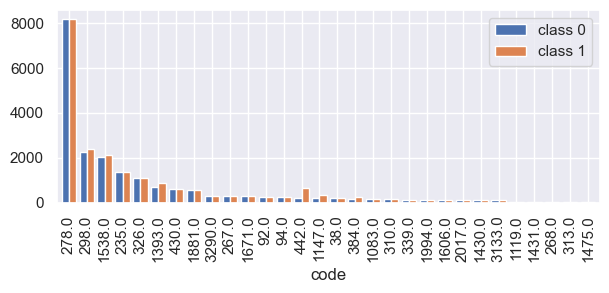

In [70]:
report_class_count_per_group(y_res, groups_res)

#### Even sample per group

In [71]:
msk_0 = y_res == 0.0
msk_1 = y_res == 1.0

x_even_0, y_even_0 = group_even_undersample(x_res[msk_0], y_res[msk_0], groups_res[msk_0], n=36, random_state=random_state)
x_even_1, y_even_1 = group_even_undersample(x_res[msk_1], y_res[msk_1], groups_res[msk_1], n=36, random_state=random_state)

y_even = pd.concat([y_even_0, y_even_1])
x_even = X.loc[y_even.index]
groups_even = groups.loc[y_even.index]
y_multi_even = Y_multi.loc[y_even.index]

print('Total samples:', len(y_even))
print()
display(y_even.value_counts())
print()
print(y_multi_even.value_counts())
print()
display(y_even.index)

Total samples: 2024



flood
0    1012
1    1012
Name: count, dtype: int64


tag
normal        538
poça          474
bolsão        377
alagamento    355
lâmina        280
Name: count, dtype: int64



Index([ 99805, 188338, 178810, 213406, 195838, 161135, 182410, 188212, 167406,
        95496,
       ...
       194236, 194246, 194235, 194244, 194241, 194247, 194240, 194245, 194239,
       194238],
      dtype='int64', length=2024)

#### Report class count per camera (only cameras with positive samples)

code,278.0,92.0,1538.0,235.0,326.0,1393.0,442.0,430.0,1881.0,1147.0,...,1994.0,1606.0,2017.0,1430.0,3133.0,1119.0,1431.0,268.0,313.0,1475.0
class 0,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,28,19,15,14
class 1,36,36,36,36,36,36,36,36,36,36,...,36,36,36,36,36,36,28,19,15,14


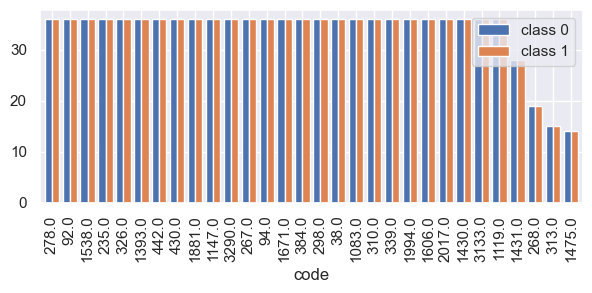

In [72]:
report_class_count_per_group(y_even, groups_even)

#### Get `x_res`, `y_res` and `groups_res`

In [73]:
x_res = X.loc[y_even.index].copy()
y_res = Y.loc[y_even.index].copy()
groups_res = groups.loc[y_even.index].copy()

---
## 5. Train and Test Splitting

####  Optional · Stratified group KFold split

Obs: Best split result

In [74]:
from sklearn.model_selection import StratifiedGroupKFold

train_prct = 0.6
test_prct = 0.2
val_prct = 0.2

n_splits_test = int(1.0 / test_prct)
n_splits_val = int((1.0 - test_prct) / val_prct)

print('n_splits_test:', n_splits_test)
print('n_splits_val:', n_splits_val)

# Stratified group KFold testing split
sgkf = StratifiedGroupKFold(n_splits=n_splits_test, shuffle=True, random_state=random_state)
for i, (train_index, test_index) in enumerate(sgkf.split(x_res, y_res, groups_res)):
    # Get first split folder
    break

X_train = x_res.iloc[train_index]
Y_train = y_res.iloc[train_index]
groups_train = groups_res.iloc[train_index]

X_test = x_res.iloc[test_index]
Y_test = y_res.iloc[test_index]
groups_test = groups_res.iloc[test_index]

# Stratified group KFold validation split
sgkf = StratifiedGroupKFold(n_splits=n_splits_val, shuffle=True, random_state=random_state)
for i, (train_index, val_index) in enumerate(sgkf.split(X_train, Y_train, groups_train)):
    break

X_val = X_train.iloc[val_index]
Y_val = Y_train.iloc[val_index]
groups_val = groups_train.iloc[val_index]

X_train = X_train.iloc[train_index]
Y_train = Y_train.iloc[train_index]
groups_train = groups_train.iloc[train_index]

print('\nTrain index:', Y_train.index[:10])
print('\nTest index:', Y_test.index[:10])
print('\nVal index:', Y_val.index[:10])

n_splits_test: 5
n_splits_val: 4

Train index: Index([106170, 173236, 223883, 223535, 180913, 177444, 75080, 127184, 173623,
       225050],
      dtype='int64')

Test index: Index([99805, 188338, 178810, 213406, 195838, 161135, 182410, 188212, 167406,
       95496],
      dtype='int64')

Val index: Index([140406, 140389, 219476, 129227, 222925, 233797, 126929, 127000, 150406,
       152797],
      dtype='int64')


#### Report split: Samples per class

In [75]:
print('Total samples:', len(y_res))
stats = group_split_report(y_res, groups_res, Y_train.index, Y_test.index, Y_val.index)
display(stats)

Total samples: 2024
Groups intersecting train and test sets: 0
Groups intersecting train and val sets: 0
Groups intersecting test and val sets: 0



,groups,groups (%),total,total (%),0,1,0 (%),1 (%),class ratio (%)
train,18.0,60.0,1160.0,57.31,580.0,580.0,57.31,57.31,50.0
test,6.0,20.0,432.0,21.34,216.0,216.0,21.34,21.34,50.0
val,6.0,20.0,432.0,21.34,216.0,216.0,21.34,21.34,50.0


#### Report split: Samples per class and code

In [161]:
group_class_count_plot(y_res, groups_res, Y_train.index, Y_test.index, Y_val.index)

---
## 6. Copy images into train and test folders

#### Copy images with `train_index`and `test_index` into structured 'train' and 'test' folders

In [77]:
from modules.octa_video_util import copy_images_to_folders

base_directory = 'data/images'
target_directory = 'data/splits/sgkf-6-2-2-size-2024-rs-3'

# dataset = data.copy()
dataset = data.copy()
file_path_field = 'file_path'
label_field = 'flood'
train_indexes = list(Y_train.index)
test_indexes = list(Y_test.index)
val_indexes = list(Y_val.index)

copy_images_to_folders(
    base_directory, target_directory, dataset,
    train_indexes, test_indexes, val_indexes,
    file_path_field=file_path_field, tag_field=label_field
)

Copying images to train folders:
Processed 1160/1160 files (100.00%) - Found: 1160/1160
Copying images to test folders:
Processed 432/432 files (100.00%) - Found: 432/432
Copying images to val folders:


#### Save dataframe of sample images

In [78]:
data_train = data.loc[Y_train.index].copy()
data_test = data.loc[Y_test.index].copy()
data_val = data.loc[Y_val.index].copy()

data_train['set'] = 'train'
data_test['set'] = 'test'
data_val['set'] = 'val'

data_split_df = pd.concat([data_train, data_test, data_val])

data_split_df.to_csv(f'{target_directory}/images.csv')
print(f'split dataframe saved with shape: {data_split_df.shape}')

split dataframe saved with shape: (2024, 13)


#### Count saved images

In [79]:
import os

print('train:', len(os.listdir(f'{target_directory}/train/0')), len(os.listdir(f'{target_directory}/train/1')))
print('test:', len(os.listdir(f'{target_directory}/test/0')), len(os.listdir(f'{target_directory}/test/1')))
print('val:', len(os.listdir(f'{target_directory}/val/0')), len(os.listdir(f'{target_directory}/val/1')))

train: 578 578
test: 216 216
val: 215 216
